In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import create_ER, dataset_nclass_ER
from models import GCN, GAEGCNEncoder
from train import Trainer, Dataset
from train_autoencoder import Trainer_Autoencoder
from embedding import Embedding
from experiments import experiment_embedding, autoencoder_embedding

import torch
torch.multiprocessing.set_sharing_strategy('file_system')
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats

import yaml

# Dataset from Planetoid

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
path = osp.join('.', 'data', 'Planetoid')
dataset_p = Planetoid(path, 'Cora', transform=transform) # choices=['Cora', 'CiteSeer', 'PubMed']
train_data, val_data, test_data = dataset_p[0]

In [5]:
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])

In [28]:
x = train_data.x.cpu().detach().numpy()
y = train_data.y.cpu().detach().numpy()

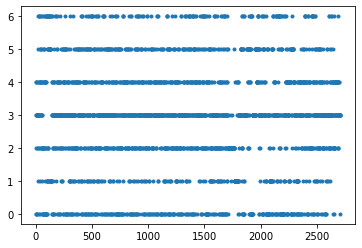

In [41]:
plt.plot(y, '.')

# Dataset nostro

In [10]:
config = yaml.safe_load(open("configs.yml"))
dataset_grafi_nx, dataset_labels, list_p= dataset_nclass_ER(config)
dataset = Dataset(dataset_grafi_nx, dataset_labels, percentage_train=0.7, batch_size=200, device=torch.device('cuda'), config=config)
dataset.prepare()

Mean connectivity for each node: 9.954 p=0.05
Mean connectivity for each node: 59.674 p=0.3


In [12]:
dataset.dataset_pyg[0]

Data(x=[200, 1], edge_index=[2, 11804], y=[1], pos_edge_label=[5902], pos_edge_label_index=[2, 5902])

### come rendere il dataset nostro adatto all'autoencoder: vuole positive e negative edges

In [8]:
my_transform = T.RandomLinkSplit(num_val=0.0, num_test=0.0, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False)

In [9]:
train_data, _, _ = my_transform(dataset.dataset_pyg[0])

(Data(x=[200, 1], edge_index=[2, 11640], y=[1], pos_edge_label=[5820], pos_edge_label_index=[2, 5820]),
 Data(x=[200, 1], edge_index=[2, 11640], y=[1], pos_edge_label=[0], pos_edge_label_index=[2, 0]),
 Data(x=[200, 1], edge_index=[2, 11640], y=[1], pos_edge_label=[0], pos_edge_label_index=[2, 0]))

# Trainer

In [2]:
config = yaml.safe_load(open("configs.yml"))
dataset_grafi_nx, dataset_labels, list_p= dataset_nclass_ER(config)

Mean connectivity for each node: 14.936 p=0.05
Mean connectivity for each node: 89.691 p=0.3


In [3]:
embeddings, trainer = autoencoder_embedding(config, dataset_grafi_nx, dataset_labels, list_p)

GAE(
  (encoder): GCN(
    (convs): ModuleList(
      (0): GCNConv(1, 128)
      (1): GCNConv(128, 128)
      (2): GCNConv(128, 1)
    )
    (pools): ModuleList(
      (0): TopKPooling(128, ratio=0.8, multiplier=1.0)
      (1): TopKPooling(128, ratio=0.8, multiplier=1.0)
      (2): TopKPooling(1, ratio=0.8, multiplier=1.0)
    )
    (leaky): LeakyReLU(negative_slope=0.03)
  )
  (decoder): InnerProductDecoder()
)
MSELoss()
Loading Dataset...
dataset_pyg len = 0
Tempo impiegato: 76.76572728157043
runs/lr-0.002_epochs55000_bs250_neurons-1-128-128-1/07Jun_02-31-14


/opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [2049,0,0], thread: [96,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [2049,0,0], thread: [97,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [2049,0,0], thread: [98,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [2049,0,0], thread: [99,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operato

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [4]:
model = GAEGCNEncoder(neurons_per_layer=config['model']['neurons_per_layer'], put_batchnorm=config['model']['put_batchnorm'])
model.to(device)
print(model)

GAE(
  (encoder): GCN(
    (convs): ModuleList(
      (0): GCNConv(1, 128)
      (1): GCNConv(128, 128)
      (2): GCNConv(128, 1)
    )
    (pools): ModuleList(
      (0): TopKPooling(128, ratio=0.8, multiplier=1.0)
      (1): TopKPooling(128, ratio=0.8, multiplier=1.0)
      (2): TopKPooling(1, ratio=0.8, multiplier=1.0)
    )
    (leaky): LeakyReLU(negative_slope=0.03)
  )
  (decoder): InnerProductDecoder()
)


In [5]:
#variational = False
trainer = Trainer_Autoencoder(model, config)
print("Loading Dataset...")
trainer.load_dataset(dataset_grafi_nx, dataset_labels, percentage_train=config['training']['percentage_train'])

MSELoss()
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████| 800/800 [01:09<00:00, 11.56it/s]


Tempo impiegato: 69.49716591835022


In [ ]:
train_loss_list, test_loss_list = trainer.launch_training()

runs/lr-0.002_epochs55000_bs250_neurons-1-128-128-1/06Jun_03-49-44


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [7]:
variational = False
config = yaml.safe_load(open("configs.yml"))
dataset_grafi_nx, dataset_labels, list_p= dataset_nclass_ER(config)

model = GAEGCNEncoder(neurons_per_layer=[1, 64, 64, 1])

In [8]:
model.to(device)
print(model)

GAE(
  (encoder): GCN(
    (convs): ModuleList(
      (0): GCNConv(1, 64)
      (1): GCNConv(64, 64)
      (2): GCNConv(64, 1)
    )
    (leaky): LeakyReLU(negative_slope=0.03)
  )
  (decoder): InnerProductDecoder()
)


In [16]:
trainer = Trainer_Autoencoder(model, config)
print("Loading Dataset...")
trainer.load_dataset(dataset_grafi_nx, dataset_labels, percentage_train=config['training']['percentage_train'])

In [17]:
train_loss_list, test_loss_list = trainer.launch_training()

<class 'list'>
runs/lr-0.005_epochs500_bs150_neurons[1, 64, 64, 32, 1]/28May_15-20-04
Epoch: 5	Test loss: 1.3860230445861816
Epoch: 10	Test loss: 1.3859854936599731
Epoch: 15	Test loss: 1.3858987092971802
Epoch: 20	Test loss: 1.385673999786377
Epoch: 25	Test loss: 1.3848068714141846
Epoch: 30	Test loss: 1.3816373348236084
Epoch: 35	Test loss: 1.369885802268982
Epoch: 40	Test loss: 1.3527567386627197
Epoch: 45	Test loss: 1.3490920066833496
Epoch: 50	Test loss: 1.337248682975769
Epoch: 55	Test loss: 1.3296481370925903
Epoch: 60	Test loss: 1.3220866918563843
Epoch: 65	Test loss: 1.3144445419311523
Epoch: 70	Test loss: 1.3221397399902344
Epoch: 75	Test loss: 1.3064844608306885
Epoch: 80	Test loss: 1.3069400787353516
Epoch: 85	Test loss: 1.3175251483917236
Epoch: 90	Test loss: 1.3330533504486084
Epoch: 95	Test loss: 1.3060673475265503
Epoch: 100	Test loss: 1.3089160919189453
Epoch: 105	Test loss: 1.3155115842819214
Epoch: 110	Test loss: 1.3125605583190918
Epoch: 115	Test loss: 1.34284734725

### Esempio pytorch

In [8]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


for epoch in range(1, 100):
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')

Epoch: 001, AUC: 0.6710, AP: 0.7055
Epoch: 002, AUC: 0.6686, AP: 0.7034
Epoch: 003, AUC: 0.6672, AP: 0.7026
Epoch: 004, AUC: 0.6669, AP: 0.7025
Epoch: 005, AUC: 0.6667, AP: 0.7032
Epoch: 006, AUC: 0.6667, AP: 0.7036
Epoch: 007, AUC: 0.6668, AP: 0.7044
Epoch: 008, AUC: 0.6667, AP: 0.7052
Epoch: 009, AUC: 0.6666, AP: 0.7060
Epoch: 010, AUC: 0.6658, AP: 0.7061
Epoch: 011, AUC: 0.6656, AP: 0.7065
Epoch: 012, AUC: 0.6651, AP: 0.7070
Epoch: 013, AUC: 0.6644, AP: 0.7079
Epoch: 014, AUC: 0.6626, AP: 0.7081
Epoch: 015, AUC: 0.6603, AP: 0.7071
Epoch: 016, AUC: 0.6586, AP: 0.7059
Epoch: 017, AUC: 0.6586, AP: 0.7055
Epoch: 018, AUC: 0.6600, AP: 0.7055
Epoch: 019, AUC: 0.6648, AP: 0.7062
Epoch: 020, AUC: 0.6806, AP: 0.7092
Epoch: 021, AUC: 0.6791, AP: 0.7088
Epoch: 022, AUC: 0.7001, AP: 0.7108
Epoch: 023, AUC: 0.7032, AP: 0.7131
Epoch: 024, AUC: 0.7001, AP: 0.7114
Epoch: 025, AUC: 0.7036, AP: 0.7093
Epoch: 026, AUC: 0.7044, AP: 0.7084
Epoch: 027, AUC: 0.7014, AP: 0.7080
Epoch: 028, AUC: 0.7072, AP: